In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
import collections
%matplotlib inline

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from statsmodels.formula.api import ols

# Raw DataFrame

In [2]:
# read in the Chicagov Divvy Bicycle Sharing Data csv files from Kaggle
pd.set_option('display.max_columns', 30)
filename = 'data.csv'
df = pd.read_csv(filename)
df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10.066667,68.0,tstorms,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4.383333,68.0,tstorms,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2.100000,68.0,tstorms,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58.016667,68.0,tstorms,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10.633333,68.0,tstorms,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [3]:
# show column types and if there are any null values present
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495235 entries, 0 to 9495234
Data columns (total 23 columns):
trip_id              9495235 non-null int64
year                 9495235 non-null int64
month                9495235 non-null int64
week                 9495235 non-null int64
day                  9495235 non-null int64
hour                 9495235 non-null int64
usertype             9495235 non-null object
gender               9495235 non-null object
starttime            9495235 non-null object
stoptime             9495235 non-null object
tripduration         9495235 non-null float64
temperature          9495235 non-null float64
events               9495235 non-null object
from_station_id      9495235 non-null int64
from_station_name    9495235 non-null object
latitude_start       9495235 non-null float64
longitude_start      9495235 non-null float64
dpcapacity_start     9495235 non-null float64
to_station_id        9495235 non-null int64
to_station_name      9495235 non-nu

# Data Cleaning and Wrangling

### Trip ID Column

In [4]:
# check for unique trip_ids
df.trip_id.value_counts();

In [5]:
# look at one instance of trip_id where there are duplicate rows
df[df['trip_id']==11693784]

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
5250863,11693784,2016,9,35,6,12,Subscriber,Male,2016-09-04 12:06:52,2016-09-04 12:12:57,6.1,78.1,cloudy,334,Lake Shore Dr & Belmont Ave,41.940775,-87.639192,19.0,117,Wilton Ave & Belmont Ave,41.94018,-87.65304,23.0
5250864,11693784,2016,9,35,6,12,Subscriber,Male,2016-09-04 12:06:52,2016-09-04 12:12:57,6.1,78.1,cloudy,334,Lake Shore Dr & Belmont Ave,41.940775,-87.639192,19.0,117,Wilton Ave & Belmont Ave,41.94018,-87.65304,23.0


In [6]:
# since there were some trip_ids with more than one count, determine the count of unique rows
df.trip_id.nunique()

9495188

In [7]:
# drop rows with duplicate data 
data = df.copy()
data = data.drop_duplicates().sort_values('trip_id')

In [8]:
# make sure the entries match our nunique count 
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9495188 entries, 576426 to 8911697
Data columns (total 23 columns):
trip_id              9495188 non-null int64
year                 9495188 non-null int64
month                9495188 non-null int64
week                 9495188 non-null int64
day                  9495188 non-null int64
hour                 9495188 non-null int64
usertype             9495188 non-null object
gender               9495188 non-null object
starttime            9495188 non-null object
stoptime             9495188 non-null object
tripduration         9495188 non-null float64
temperature          9495188 non-null float64
events               9495188 non-null object
from_station_id      9495188 non-null int64
from_station_name    9495188 non-null object
latitude_start       9495188 non-null float64
longitude_start      9495188 non-null float64
dpcapacity_start     9495188 non-null float64
to_station_id        9495188 non-null int64
to_station_name      9495188 n

In [9]:
# check each trip id has a single count
data.trip_id.value_counts();

The duplicate trip_ids have been dropped, so each trip_id is a unique event. There are 9495188 values in every column, and there are no null values. 

### General cleaning steps for easier use

In [10]:
# convert start and stop times to datetimes
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

In [11]:
# rename day column to numerical day of week
data = data.rename(columns={'day':'num_day_of_week'})

In [12]:
# create new column with the name of the week 
data['day_of_week'] = data['starttime'].dt.weekday_name

In [13]:
# create new column with numerical day of the month
data['day'] = data['starttime'].dt.day

In [14]:
# view tail of the data
pd.set_option('display.max_columns', 30)
data.tail()

,trip_id,year,month,week,num_day_of_week,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,day_of_week,day
8911701,17536695,2017,12,52,6,23,Subscriber,Male,2017-12-31 23:34:00,2017-12-31 23:39:00,5.016667,-0.9,clear,337,Clark St & Chicago Ave,41.896544,-87.630931,19.0,182,Wells St & Elm St,41.903222,-87.634324,23.0,Sunday,31
8911700,17536696,2017,12,52,6,23,Subscriber,Male,2017-12-31 23:41:00,2017-12-31 23:51:00,9.816667,-0.9,clear,93,Sheffield Ave & Willow St,41.913688,-87.652855,15.0,343,Racine Ave & Wrightwood Ave,41.928887,-87.658971,15.0,Sunday,31
8911699,17536697,2017,12,52,6,23,Subscriber,Male,2017-12-31 23:42:00,2017-12-31 23:47:00,4.533333,-0.9,clear,240,Sheridan Rd & Irving Park Rd,41.954245,-87.654406,27.0,245,Clarendon Ave & Junior Ter,41.961004,-87.649603,23.0,Sunday,31
8911698,17536698,2017,12,52,6,23,Subscriber,Male,2017-12-31 23:48:00,2017-12-31 23:53:00,5.250000,-0.9,clear,340,Clark St & Wrightwood Ave,41.929546,-87.643118,15.0,143,Sedgwick St & Webster Ave,41.922167,-87.638888,15.0,Sunday,31
8911697,17536701,2017,12,52,6,23,Subscriber,Male,2017-12-31 23:58:00,2018-01-01 00:03:00,4.733333,-0.9,clear,159,Claremont Ave & Hirsch St,41.907781,-87.685854,11.0,69,Damen Ave & Pierce Ave,41.909396,-87.677692,19.0,Sunday,31


In [15]:
# sort columns
pd.set_option('display.max_columns', 30)
data = data[['trip_id','year','month','week','day','hour','num_day_of_week','day_of_week',
             'starttime','stoptime','tripduration','temperature','events','usertype','gender',
             'from_station_id','from_station_name','latitude_start','longitude_start','dpcapacity_start',
             'to_station_id','to_station_name','latitude_end','longitude_end','dpcapacity_end']]
data

,trip_id,year,month,week,day,hour,num_day_of_week,day_of_week,starttime,stoptime,tripduration,temperature,events,usertype,gender,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
576426,1109427,2014,1,1,1,1,2,Wednesday,2014-01-01 01:12:00,2014-01-01 01:18:00,5.766667,10.9,not clear,Subscriber,Male,240,Sheridan Rd & Irving Park Rd,41.954245,-87.654406,23.0,245,Clarendon Ave & Junior Ter,41.961004,-87.649603,15.0
576425,1109431,2014,1,1,1,1,2,Wednesday,2014-01-01 01:43:00,2014-01-01 01:53:00,10.833333,10.9,not clear,Subscriber,Male,113,Bissell St & Armitage Ave,41.918440,-87.652220,15.0,94,Clark St & Armitage Ave,41.918306,-87.636282,19.0
576424,1109432,2014,1,1,1,1,2,Wednesday,2014-01-01 01:43:00,2014-01-01 01:53:00,10.866667,10.9,not clear,Subscriber,Male,113,Bissell St & Armitage Ave,41.918440,-87.652220,15.0,94,Clark St & Armitage Ave,41.918306,-87.636282,19.0
576423,1109434,2014,1,1,1,1,2,Wednesday,2014-01-01 01:44:00,2014-01-01 01:59:00,15.266667,10.9,not clear,Subscriber,Male,50,Clark St & Congress Pkwy,41.875933,-87.630585,27.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0
576422,1109435,2014,1,1,1,1,2,Wednesday,2014-01-01 01:45:00,2014-01-01 02:00:00,15.066667,10.9,not clear,Subscriber,Female,50,Clark St & Congress Pkwy,41.875933,-87.630585,27.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0
576421,1109439,2014,1,1,1,1,2,Wednesday,2014-01-01 01:49:00,2014-01-01 01:57:00,8.466667,10.9,not clear,Subscriber,Male,250,Ashland Ave & Wellington Ave,41.936083,-87.669807,19.0,115,Sheffield Ave & Wellington Ave,41.936253,-87.653566,23.0
576420,1109440,2014,1,1,1,1,2,Wednesday,2014-01-01 01:53:00,2014-01-01 02:00:00,7.033333,10.9,not clear,Subscriber,Male,213,Leavitt St & North Ave,41.910153,-87.682290,15.0,183,Damen Ave & Augusta Blvd,41.899714,-87.677234,15.0
576419,1109441,2014,1,1,1,1,2,Wednesday,2014-01-01 01:57:00,2014-01-01 02:08:00,10.316667,10.9,not clear,Subscriber,Male,199,Wabash Ave & Grand Ave,41.891738,-87.626937,15.0,26,McClurg Ct & Illinois St,41.891020,-87.617300,31.0
576418,1109442,2014,1,1,1,1,2,Wednesday,2014-01-01 01:58:00,2014-01-01 02:05:00,7.166667,10.9,not clear,Subscriber,Male,141,Clark St & Lincoln Ave,41.915689,-87.634600,23.0,141,Clark St & Lincoln Ave,41.915689,-87.634600,23.0
576417,1109443,2014,1,1,1,1,2,Wednesday,2014-01-01 01:59:00,2014-01-01 02:06:00,7.466667,10.9,not clear,Subscriber,Male,141,Clark St & Lincoln Ave,41.915689,-87.634600,23.0,141,Clark St & Lincoln Ave,41.915689,-87.634600,23.0


### Datetime: year, month, week, day, hour

#### year

In [16]:
# value counts of the number of trip sorted by year
data.year.value_counts().sort_index()

2014    1615683
2015    2220509
2016    2701306
2017    2957690
Name: year, dtype: int64

#### month

In [17]:
# value counts of the number of trip sorted by month
data.month.value_counts().sort_index()

1      271715
2      305975
3      437929
4      621688
5      869584
6     1178225
7     1279494
8     1304671
9     1189967
10     997712
11     643556
12     394672
Name: month, dtype: int64

Text(0,0.5,'Percentage of Trips Taken')

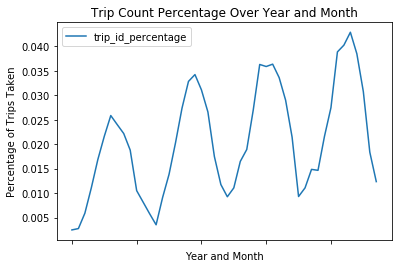

In [18]:
# group the year and month data, see how trips vary with time
year_month = data.groupby(['year','month']).agg({'trip_id': 'size'}).reset_index()
year_month['date']=year_month['year'].astype(str)+'_'+year_month['month'].astype(str)
year_month['trip_id_percentage'] = year_month['trip_id'] / year_month['trip_id'].sum()
year_month.plot(x='date',y='trip_id_percentage')
plt.title('Trip Count Percentage Over Year and Month')
plt.xlabel('Year and Month')
plt.ylabel('Percentage of Trips Taken')

#### week

In [19]:
# value counts of the number of trip sorted by week
data.week.value_counts().sort_index()

1      49800
2      47473
3      67921
4      78123
5      74277
6      59121
7      87040
8      83869
9      72647
10     96500
11    102597
12    107063
13     99192
14    109154
15    151660
16    169861
17    148145
18    170309
19    178501
20    205441
21    216299
22    236001
23    271623
24    265853
25    276307
26    279111
27    265553
28    284936
29    288015
30    309620
31    307316
32    304272
33    289279
34    291018
35    281243
36    268179
37    274913
38    286354
39    276485
40    250157
41    239413
42    236977
43    201714
44    192547
45    192060
46    160961
47    105549
48    121933
49    110308
50    103559
51     92442
52     46894
53      9603
Name: week, dtype: int64

Text(0,0.5,'Percentage of Trips Taken')

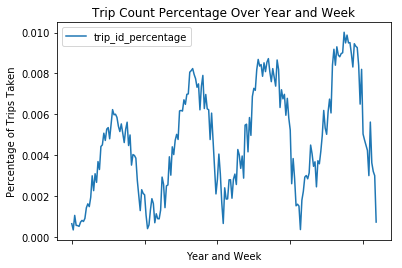

In [20]:
# group the year and week data, see how trips vary with time
year_week = data.groupby(['year','week']).agg({'trip_id': 'size'}).reset_index()
year_week['date']=year_week['year'].astype(str)+'_'+year_week['week'].astype(str)
year_week['trip_id_percentage'] = year_week['trip_id'] / year_week['trip_id'].sum()
year_week.plot(x='date',y='trip_id_percentage')
plt.title('Trip Count Percentage Over Year and Week')
plt.xlabel('Year and Week')
plt.ylabel('Percentage of Trips Taken')

#### day

In [21]:
# value counts of the number of trip sorted by day
data.day.value_counts().sort_index()

1     304484
2     305318
3     308467
4     282830
5     301737
6     312738
7     321379
8     326684
9     321005
10    300871
11    316623
12    294333
13    309320
14    313579
15    321560
16    326423
17    327984
18    331511
19    319799
20    322790
21    330588
22    327917
23    303519
24    288269
25    304927
26    292424
27    306638
28    307530
29    300045
30    285691
31    178205
Name: day, dtype: int64

#### hour

In [22]:
# value counts of the number of trip sorted by hour
data.hour.value_counts().sort_index();

In [23]:
# percentage of trips taken during different hours
((data.hour.value_counts()/data.hour.count()) * 100).sort_index()

0      0.649497
1      0.386153
2      0.224061
3      0.135521
4      0.184504
5      0.905890
6      3.264717
7      7.305753
8      9.362205
9      4.678938
10     3.530567
11     4.268868
12     4.934036
13     4.790648
14     4.564881
15     5.573444
16     9.178502
17    12.758168
18     8.512680
19     5.529306
20     3.645878
21     2.639516
22     1.866303
23     1.109962
Name: hour, dtype: float64

### Day of Week

In [24]:
# percentage of trips taken by different gender
(data['day_of_week'].value_counts()/data['day_of_week'].count()) * 100

Tuesday      16.752928
Wednesday    16.197984
Thursday     16.120460
Monday       15.551467
Friday       15.359928
Saturday     10.315025
Sunday        9.702209
Name: day_of_week, dtype: float64

In [25]:
# value counts of trips taken on different days of the week
data['day_of_week'].value_counts().sort_index()

Friday       1458454
Monday       1476641
Saturday      979431
Sunday        921243
Thursday     1530668
Tuesday      1590722
Wednesday    1538029
Name: day_of_week, dtype: int64

In [26]:
# value counts of trips taken on different days of the week (numerical)
data['num_day_of_week'].value_counts().sort_index()

0    1476641
1    1590722
2    1538029
3    1530668
4    1458454
5     979431
6     921243
Name: num_day_of_week, dtype: int64

### Usertype and Gender

In [27]:
# percentage of trips taken by different usertypes
(data.usertype.value_counts()/data.usertype.count()) * 100

Subscriber    99.984676
Customer       0.013449
Dependent      0.001875
Name: usertype, dtype: float64

In [28]:
# percentage of trips taken by different gender
(data.gender.value_counts()/data.gender.count()) * 100

Male      74.948785
Female    25.051215
Name: gender, dtype: float64

### Duration

In [29]:
# see how the difference in stop/start time compares to the trip duration 
data['difference'] = data['stoptime'] - data['starttime']
data['tripduration_round'] = data['tripduration'].round(0)
data[['difference','tripduration_round']];

Text(0,0.5,'Number of Trips')

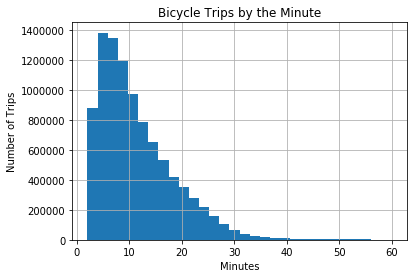

In [30]:
# histogram of trip durations
data.hist('tripduration', bins=30)
plt.title('Bicycle Trips by the Minute')
plt.xlabel('Minutes')
plt.ylabel('Number of Trips')

### Temperature and Weather 

Text(0,0.5,'Number of Trips')

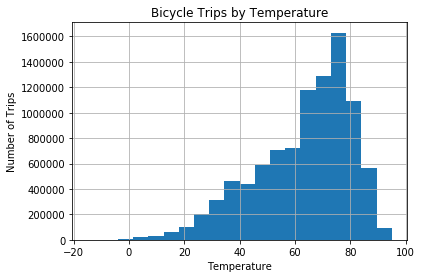

In [31]:
# histogram of the temperature data
data.hist('temperature', bins=20)
plt.title('Bicycle Trips by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Trips')

In [32]:
# weather events
data.events.value_counts()

cloudy          8398455
clear            511818
rain or snow     432077
not clear         88159
tstorms           64143
unknown             536
Name: events, dtype: int64

Text(0,0.5,'Number of Trips')

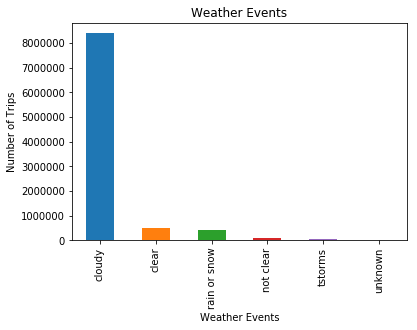

In [33]:
# bar chart to show relative frequencies of each weather event
data.events.value_counts().plot(kind='bar')
plt.title('Weather Events')
plt.xlabel('Weather Events')
plt.ylabel('Number of Trips')

### Stations

In [34]:
# create two lists with unique station ID's 
x = data['from_station_id'].drop_duplicates()
y = data['to_station_id'].drop_duplicates()

In [35]:
# see if multisets are equal 
collections.Counter(x) == collections.Counter(y)

True

In [36]:
data['to_station_name'].nunique()

656

In [37]:
data['from_station_name'].nunique()

656

### Location

In [38]:
# check maximum values to see if they are within reason with Chicago latitude and longitude
data[['latitude_start','longitude_start','latitude_end','longitude_end']].max()

latitude_start     42.064313
longitude_start   -87.549386
latitude_end       42.064313
longitude_end     -87.549386
dtype: float64

In [39]:
# check minimum values to see if they are within reason with Chicago latitude and longitude
data[['latitude_start','longitude_start','latitude_end','longitude_end']].min()

latitude_start     41.736646
longitude_start   -87.802870
latitude_end       41.736646
longitude_end     -87.802870
dtype: float64

### Capacity

### end of day counts for each station

In [40]:
# show that some stations have multiple capacity counts
dfstart = data[['starttime','from_station_name','dpcapacity_start']].sort_values('from_station_name').drop_duplicates(subset=['from_station_name', 'dpcapacity_start'], keep='first')


In [41]:
# shows stations with multiple capacities, and the date that it was first implemented
dfstart[dfstart.duplicated('from_station_name', keep=False) == True]

,starttime,from_station_name,dpcapacity_start
27052,2014-06-26 20:44:00,Adler Planetarium,19.0
8682968,2017-07-19 18:34:33,Adler Planetarium,39.0
7593924,2017-04-24 19:33:18,Adler Planetarium,35.0
2901411,2015-08-11 12:26:00,Albany Ave & 26th St,19.0
7802056,2017-09-27 13:33:34,Albany Ave & 26th St,11.0
5983868,2016-12-26 15:53:04,Ashland Ave & Archer Ave,19.0
9262240,2017-10-23 22:10:00,Ashland Ave & Archer Ave,15.0
7221251,2017-06-06 18:37:35,Avers Ave & Belmont Ave,11.0
4089478,2016-02-03 06:29:00,Avers Ave & Belmont Ave,19.0
8207358,2017-08-25 11:53:11,Blackstone Ave & Hyde Park Blvd,19.0


In [42]:
dfstart.head()

,starttime,from_station_name,dpcapacity_start
5300229,2016-08-30 19:19:45,2112 W Peterson Ave,15.0
3698633,2015-10-16 10:51:00,63rd St Beach,23.0
424189,2014-04-15 18:17:00,900 W Harrison,19.0
3422841,2015-11-29 21:59:00,900 W Harrison St,19.0
4830115,2016-06-13 16:10:00,Aberdeen St & Jackson Blvd,15.0


In [43]:
dfstart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 5300229 to 9402259
Data columns (total 3 columns):
starttime            837 non-null datetime64[ns]
from_station_name    837 non-null object
dpcapacity_start     837 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.2+ KB


In [44]:
# show that some stations have multiple capacity counts
dfend = data[['stoptime','to_station_name','dpcapacity_end']].sort_values('to_station_name').drop_duplicates(subset=['to_station_name', 'dpcapacity_end'], keep='first')


In [45]:
dfend.head()

,stoptime,to_station_name,dpcapacity_end
8640049,2017-07-23 22:08:31,2112 W Peterson Ave,15.0
4656682,2016-06-28 13:42:00,63rd St Beach,23.0
303804,2014-05-14 09:01:00,900 W Harrison,19.0
2521310,2015-07-18 20:43:00,900 W Harrison St,19.0
952232,2014-09-12 16:29:00,Aberdeen St & Jackson Blvd,15.0


In [46]:
dfend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 8640049 to 4589165
Data columns (total 3 columns):
stoptime           837 non-null datetime64[ns]
to_station_name    837 non-null object
dpcapacity_end     837 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.2+ KB


In [47]:
# see that they match on name and capacity and have the same number of rows; shows that the values are consistent
capacities = pd.merge(dfstart, dfend, how='outer', left_on=['from_station_name','dpcapacity_start'], right_on=['to_station_name','dpcapacity_end']).sort_values(['from_station_name'])



In [48]:
capacities.head()

,starttime,from_station_name,dpcapacity_start,stoptime,to_station_name,dpcapacity_end
0,2016-08-30 19:19:45,2112 W Peterson Ave,15.0,2017-07-23 22:08:31,2112 W Peterson Ave,15.0
1,2015-10-16 10:51:00,63rd St Beach,23.0,2016-06-28 13:42:00,63rd St Beach,23.0
2,2014-04-15 18:17:00,900 W Harrison,19.0,2014-05-14 09:01:00,900 W Harrison,19.0
3,2015-11-29 21:59:00,900 W Harrison St,19.0,2015-07-18 20:43:00,900 W Harrison St,19.0
4,2016-06-13 16:10:00,Aberdeen St & Jackson Blvd,15.0,2014-09-12 16:29:00,Aberdeen St & Jackson Blvd,15.0


In [49]:
capacities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 6 columns):
starttime            837 non-null datetime64[ns]
from_station_name    837 non-null object
dpcapacity_start     837 non-null float64
stoptime             837 non-null datetime64[ns]
to_station_name      837 non-null object
dpcapacity_end       837 non-null float64
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 45.8+ KB


In [50]:
# see that they match on name and capacity and have the same number of rows; shows that the values are consistent
innercapacities = pd.merge(dfstart, dfend, how='outer', left_on=['from_station_name','dpcapacity_start'], right_on=['to_station_name','dpcapacity_end']).sort_values(['from_station_name'])



In [51]:
innercapacities.head()

,starttime,from_station_name,dpcapacity_start,stoptime,to_station_name,dpcapacity_end
0,2016-08-30 19:19:45,2112 W Peterson Ave,15.0,2017-07-23 22:08:31,2112 W Peterson Ave,15.0
1,2015-10-16 10:51:00,63rd St Beach,23.0,2016-06-28 13:42:00,63rd St Beach,23.0
2,2014-04-15 18:17:00,900 W Harrison,19.0,2014-05-14 09:01:00,900 W Harrison,19.0
3,2015-11-29 21:59:00,900 W Harrison St,19.0,2015-07-18 20:43:00,900 W Harrison St,19.0
4,2016-06-13 16:10:00,Aberdeen St & Jackson Blvd,15.0,2014-09-12 16:29:00,Aberdeen St & Jackson Blvd,15.0


In [52]:
innercapacities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 6 columns):
starttime            837 non-null datetime64[ns]
from_station_name    837 non-null object
dpcapacity_start     837 non-null float64
stoptime             837 non-null datetime64[ns]
to_station_name      837 non-null object
dpcapacity_end       837 non-null float64
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 45.8+ KB


In [53]:
# drop columns
capacities = capacities.drop(['to_station_name', 'dpcapacity_end'], axis=1)

In [54]:
capacities = capacities.rename(columns={'from_station_name':'station_name',
                                       'dpcapacity_start':'capacity'})
capacities.sort_values('station_name');

In [55]:
capacities['datetime'] = capacities[['starttime','stoptime']].max(axis=1).dt.date

In [56]:
capacities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 5 columns):
starttime       837 non-null datetime64[ns]
station_name    837 non-null object
capacity        837 non-null float64
stoptime        837 non-null datetime64[ns]
datetime        837 non-null object
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 39.2+ KB


In [57]:
capacities = capacities.drop(['starttime','stoptime'], axis=1)

In [58]:
capacities.head()

,station_name,capacity,datetime
0,2112 W Peterson Ave,15.0,2017-07-23
1,63rd St Beach,23.0,2016-06-28
2,900 W Harrison,19.0,2014-05-14
3,900 W Harrison St,19.0,2015-11-29
4,Aberdeen St & Jackson Blvd,15.0,2016-06-13


In [59]:
capacities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 3 columns):
station_name    837 non-null object
capacity        837 non-null float64
datetime        837 non-null object
dtypes: float64(1), object(2)
memory usage: 26.2+ KB


In [60]:
capacities['station_name'].nunique()

656

In [61]:
capacities = capacities[['datetime','station_name','capacity']]
capacities = capacities.sort_values(['datetime','station_name'])

In [62]:
capacities.head()

,datetime,station_name,capacity
708,2014-03-06,State St & Erie St,23.0
136,2014-04-11,Cityfront Plaza & N Water St,19.0
833,2014-04-21,Woodlawn Ave & 55th St,15.0
272,2014-05-13,Eckhart Park,15.0
2,2014-05-14,900 W Harrison,19.0


In [63]:
alldate_capacity = pd.date_range('2014-01-01', '2017-12-31')
idx = pd.MultiIndex.from_product((alldate_capacity, capacities['station_name'].unique()))
filled_capacity = capacities.set_index(['datetime','station_name']).reindex(idx).reset_index().set_axis(capacities.columns, axis=1, inplace=False)



In [64]:
filled_capacity = filled_capacity.sort_values(['station_name','datetime'])

In [65]:
filled_capacity['capacity'] = filled_capacity.groupby('station_name')['capacity'].transform(lambda v: v.ffill())



In [66]:
filled_capacity['capacity'] = filled_capacity.groupby('station_name')['capacity'].transform(lambda w: w.bfill())



In [67]:
filled_capacity.head()

,datetime,station_name,capacity
480,2014-01-01,2112 W Peterson Ave,15.0
1136,2014-01-02,2112 W Peterson Ave,15.0
1792,2014-01-03,2112 W Peterson Ave,15.0
2448,2014-01-04,2112 W Peterson Ave,15.0
3104,2014-01-05,2112 W Peterson Ave,15.0


In [68]:
filled_capacity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958416 entries, 480 to 958353
Data columns (total 3 columns):
datetime        958416 non-null datetime64[ns]
station_name    958416 non-null object
capacity        958416 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 29.2+ MB


In [69]:
filled_capacity['datetime'] = filled_capacity['datetime'].dt.strftime('%Y-%m-%d')
filled_capacity.head()


,datetime,station_name,capacity
480,2014-01-01,2112 W Peterson Ave,15.0
1136,2014-01-02,2112 W Peterson Ave,15.0
1792,2014-01-03,2112 W Peterson Ave,15.0
2448,2014-01-04,2112 W Peterson Ave,15.0
3104,2014-01-05,2112 W Peterson Ave,15.0


In [70]:
filled_capacity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958416 entries, 480 to 958353
Data columns (total 3 columns):
datetime        958416 non-null object
station_name    958416 non-null object
capacity        958416 non-null float64
dtypes: float64(1), object(2)
memory usage: 29.2+ MB


In [71]:
data['date'] = data['starttime'].dt.strftime('%Y-%m-%d')
data.head()

,trip_id,year,month,week,day,hour,num_day_of_week,day_of_week,starttime,stoptime,tripduration,temperature,events,usertype,gender,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,difference,tripduration_round,date
576426,1109427,2014,1,1,1,1,2,Wednesday,2014-01-01 01:12:00,2014-01-01 01:18:00,5.766667,10.9,not clear,Subscriber,Male,240,Sheridan Rd & Irving Park Rd,41.954245,-87.654406,23.0,245,Clarendon Ave & Junior Ter,41.961004,-87.649603,15.0,00:06:00,6.0,2014-01-01
576425,1109431,2014,1,1,1,1,2,Wednesday,2014-01-01 01:43:00,2014-01-01 01:53:00,10.833333,10.9,not clear,Subscriber,Male,113,Bissell St & Armitage Ave,41.918440,-87.652220,15.0,94,Clark St & Armitage Ave,41.918306,-87.636282,19.0,00:10:00,11.0,2014-01-01
576424,1109432,2014,1,1,1,1,2,Wednesday,2014-01-01 01:43:00,2014-01-01 01:53:00,10.866667,10.9,not clear,Subscriber,Male,113,Bissell St & Armitage Ave,41.918440,-87.652220,15.0,94,Clark St & Armitage Ave,41.918306,-87.636282,19.0,00:10:00,11.0,2014-01-01
576423,1109434,2014,1,1,1,1,2,Wednesday,2014-01-01 01:44:00,2014-01-01 01:59:00,15.266667,10.9,not clear,Subscriber,Male,50,Clark St & Congress Pkwy,41.875933,-87.630585,27.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,00:15:00,15.0,2014-01-01
576422,1109435,2014,1,1,1,1,2,Wednesday,2014-01-01 01:45:00,2014-01-01 02:00:00,15.066667,10.9,not clear,Subscriber,Female,50,Clark St & Congress Pkwy,41.875933,-87.630585,27.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,00:15:00,15.0,2014-01-01


#### departures

In [72]:
daily_trip_departures = data.groupby(['date','from_station_name'])['trip_id'].size().reset_index()
daily_trip_departures.head()

,date,from_station_name,trip_id
0,2014-01-01,Ashland Ave & Augusta Blvd,1
1,2014-01-01,Ashland Ave & Chicago Ave,1
2,2014-01-01,Ashland Ave & Division St,2
3,2014-01-01,Ashland Ave & Wellington Ave,1
4,2014-01-01,Bissell St & Armitage Ave,5


In [73]:
daily_trip_departures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554433 entries, 0 to 554432
Data columns (total 3 columns):
date                 554433 non-null object
from_station_name    554433 non-null object
trip_id              554433 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.7+ MB


In [74]:
departures = pd.merge(daily_trip_departures, filled_capacity, how='left', left_on=['date','from_station_name'],right_on=['datetime','station_name'])
departures.head()

,date,from_station_name,trip_id,datetime,station_name,capacity
0,2014-01-01,Ashland Ave & Augusta Blvd,1,2014-01-01,Ashland Ave & Augusta Blvd,15.0
1,2014-01-01,Ashland Ave & Chicago Ave,1,2014-01-01,Ashland Ave & Chicago Ave,15.0
2,2014-01-01,Ashland Ave & Division St,2,2014-01-01,Ashland Ave & Division St,19.0
3,2014-01-01,Ashland Ave & Wellington Ave,1,2014-01-01,Ashland Ave & Wellington Ave,19.0
4,2014-01-01,Bissell St & Armitage Ave,5,2014-01-01,Bissell St & Armitage Ave,15.0


In [75]:
departures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554433 entries, 0 to 554432
Data columns (total 6 columns):
date                 554433 non-null object
from_station_name    554433 non-null object
trip_id              554433 non-null int64
datetime             554433 non-null object
station_name         554433 non-null object
capacity             554433 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 29.6+ MB


In [76]:
departures = departures.rename(columns={'trip_id':'trip_departures','capacity':'departure_capacity'})
departures = departures[['date','from_station_name','trip_departures','departure_capacity']]

In [77]:
departures.head()

,date,from_station_name,trip_departures,departure_capacity
0,2014-01-01,Ashland Ave & Augusta Blvd,1,15.0
1,2014-01-01,Ashland Ave & Chicago Ave,1,15.0
2,2014-01-01,Ashland Ave & Division St,2,19.0
3,2014-01-01,Ashland Ave & Wellington Ave,1,19.0
4,2014-01-01,Bissell St & Armitage Ave,5,15.0


In [78]:
departures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554433 entries, 0 to 554432
Data columns (total 4 columns):
date                  554433 non-null object
from_station_name     554433 non-null object
trip_departures       554433 non-null int64
departure_capacity    554433 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 21.1+ MB


#### arrivals

In [79]:
daily_trip_arrivals = data.groupby(['date','to_station_name'])['trip_id'].size().reset_index()
daily_trip_arrivals.head()

,date,to_station_name,trip_id
0,2014-01-01,Ashland Ave & Blackhawk St,1
1,2014-01-01,Blue Island Ave & 18th St,1
2,2014-01-01,Canal St & Madison St,2
3,2014-01-01,Clarendon Ave & Gordon Ter,1
4,2014-01-01,Clarendon Ave & Junior Ter,2


In [80]:
daily_trip_arrivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551751 entries, 0 to 551750
Data columns (total 3 columns):
date               551751 non-null object
to_station_name    551751 non-null object
trip_id            551751 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.6+ MB


In [81]:
arrivals = pd.merge(daily_trip_arrivals, filled_capacity, how='left', left_on=['date','to_station_name'],right_on=['datetime','station_name'])
arrivals.head()

,date,to_station_name,trip_id,datetime,station_name,capacity
0,2014-01-01,Ashland Ave & Blackhawk St,1,2014-01-01,Ashland Ave & Blackhawk St,15.0
1,2014-01-01,Blue Island Ave & 18th St,1,2014-01-01,Blue Island Ave & 18th St,15.0
2,2014-01-01,Canal St & Madison St,2,2014-01-01,Canal St & Madison St,23.0
3,2014-01-01,Clarendon Ave & Gordon Ter,1,2014-01-01,Clarendon Ave & Gordon Ter,15.0
4,2014-01-01,Clarendon Ave & Junior Ter,2,2014-01-01,Clarendon Ave & Junior Ter,15.0


In [82]:
arrivals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551751 entries, 0 to 551750
Data columns (total 6 columns):
date               551751 non-null object
to_station_name    551751 non-null object
trip_id            551751 non-null int64
datetime           551751 non-null object
station_name       551751 non-null object
capacity           551751 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 29.5+ MB


In [83]:
arrivals = arrivals.rename(columns={'trip_id':'trip_arrivals','capacity':'arrival_capacity'})
arrivals = arrivals[['date','to_station_name','trip_arrivals','arrival_capacity']]

In [84]:
arrivals.head()

,date,to_station_name,trip_arrivals,arrival_capacity
0,2014-01-01,Ashland Ave & Blackhawk St,1,15.0
1,2014-01-01,Blue Island Ave & 18th St,1,15.0
2,2014-01-01,Canal St & Madison St,2,23.0
3,2014-01-01,Clarendon Ave & Gordon Ter,1,15.0
4,2014-01-01,Clarendon Ave & Junior Ter,2,15.0


In [85]:
arrivals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551751 entries, 0 to 551750
Data columns (total 4 columns):
date                551751 non-null object
to_station_name     551751 non-null object
trip_arrivals       551751 non-null int64
arrival_capacity    551751 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 21.0+ MB


### join arrivals and departures

In [86]:
tripdf = pd.merge(departures, arrivals, how='outer', left_on=['date','from_station_name'], right_on=['date','to_station_name'])
tripdf.head()

,date,from_station_name,trip_departures,departure_capacity,to_station_name,trip_arrivals,arrival_capacity
0,2014-01-01,Ashland Ave & Augusta Blvd,1.0,15.0,NaN,NaN,NaN
1,2014-01-01,Ashland Ave & Chicago Ave,1.0,15.0,NaN,NaN,NaN
2,2014-01-01,Ashland Ave & Division St,2.0,19.0,NaN,NaN,NaN
3,2014-01-01,Ashland Ave & Wellington Ave,1.0,19.0,NaN,NaN,NaN
4,2014-01-01,Bissell St & Armitage Ave,5.0,15.0,NaN,NaN,NaN


In [87]:
tripdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576538 entries, 0 to 576537
Data columns (total 7 columns):
date                  576538 non-null object
from_station_name     554433 non-null object
trip_departures       554433 non-null float64
departure_capacity    554433 non-null float64
to_station_name       551751 non-null object
trip_arrivals         551751 non-null float64
arrival_capacity      551751 non-null float64
dtypes: float64(4), object(3)
memory usage: 35.2+ MB


In [88]:
tripdf['trip_departures'] = tripdf['trip_departures'].fillna(0)
tripdf['trip_arrivals'] = tripdf['trip_arrivals'].fillna(0)

tripdf['from_station_name'] = tripdf['from_station_name'].fillna(tripdf['to_station_name'])
tripdf['departure_capacity'] = tripdf['departure_capacity'].fillna(tripdf['arrival_capacity'])

tripdf['to_station_name'] = tripdf['to_station_name'].fillna(tripdf['from_station_name'])
tripdf['arrival_capacity'] = tripdf['arrival_capacity'].fillna(tripdf['departure_capacity'])

tripdf = tripdf.sort_values('from_station_name')

In [89]:
capacitydf = tripdf[['date','from_station_name','departure_capacity','trip_departures','trip_arrivals']]

capacitydf = capacitydf.rename(columns={'from_station_name':'station_name','departure_capacity':'capacity'})

In [90]:
capacitydf.head()

,date,station_name,capacity,trip_departures,trip_arrivals
284082,2016-05-17,2112 W Peterson Ave,15.0,1.0,0.0
575913,2017-12-12,2112 W Peterson Ave,15.0,0.0,1.0
548965,2017-12-16,2112 W Peterson Ave,15.0,2.0,2.0
564921,2016-03-29,2112 W Peterson Ave,15.0,0.0,1.0
355213,2016-10-15,2112 W Peterson Ave,15.0,3.0,4.0


In [91]:
capacitydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576538 entries, 284082 to 573827
Data columns (total 5 columns):
date               576538 non-null object
station_name       576538 non-null object
capacity           576538 non-null float64
trip_departures    576538 non-null float64
trip_arrivals      576538 non-null float64
dtypes: float64(3), object(2)
memory usage: 26.4+ MB


In [92]:
# assuming full capacity at the beginning of the day, end_cap is the end of the day capacity
capacitydf['end_cap'] = capacitydf['capacity'] - capacitydf['trip_departures'] + capacitydf['trip_arrivals']

In [93]:
capacitydf.head()

,date,station_name,capacity,trip_departures,trip_arrivals,end_cap
284082,2016-05-17,2112 W Peterson Ave,15.0,1.0,0.0,14.0
575913,2017-12-12,2112 W Peterson Ave,15.0,0.0,1.0,16.0
548965,2017-12-16,2112 W Peterson Ave,15.0,2.0,2.0,15.0
564921,2016-03-29,2112 W Peterson Ave,15.0,0.0,1.0,16.0
355213,2016-10-15,2112 W Peterson Ave,15.0,3.0,4.0,16.0


In [94]:
capacitydf.capacity.value_counts().sort_index()

0.0        134
9.0       1083
11.0     54572
12.0        18
14.0      1342
15.0    305127
16.0      1175
19.0    129034
20.0       631
23.0     43951
27.0     16770
28.0       271
31.0      9740
35.0      5167
36.0       776
39.0      3144
43.0      1744
47.0      1548
51.0       174
55.0       137
Name: capacity, dtype: int64

In [95]:
capacitydf.end_cap.value_counts().sort_index()

-136.0     1
-95.0      1
-85.0      1
-83.0      1
-82.0      2
-81.0      1
-77.0      1
-76.0      2
-73.0      1
-71.0      1
-70.0      1
-69.0      1
-67.0      4
-66.0      2
-65.0      2
-64.0      2
-58.0      4
-57.0      2
-56.0      2
-55.0      3
-54.0      2
-53.0      2
-52.0      5
-51.0      4
-50.0      4
-49.0     11
-48.0      7
-47.0      7
-46.0      6
-45.0      5
          ..
 100.0     2
 101.0     4
 103.0     3
 104.0     4
 105.0     1
 106.0     2
 107.0     3
 108.0     2
 109.0     2
 110.0     2
 111.0     2
 112.0     1
 113.0     2
 114.0     1
 115.0     1
 116.0     1
 117.0     1
 118.0     1
 119.0     3
 121.0     1
 122.0     2
 123.0     1
 124.0     1
 126.0     2
 127.0     2
 133.0     1
 134.0     1
 137.0     1
 139.0     1
 142.0     1
Name: end_cap, Length: 204, dtype: int64

### end of hour counts for each station

In [96]:
# show that some stations have multiple capacity counts
dfstart1 = data[['starttime','from_station_name','dpcapacity_start']].sort_values('from_station_name').drop_duplicates(subset=['from_station_name', 'dpcapacity_start'], keep='first')


In [97]:
# shows stations with multiple capacities, and the date that it was first implemented
dfstart1[dfstart1.duplicated('from_station_name', keep=False) == True]



,starttime,from_station_name,dpcapacity_start
27052,2014-06-26 20:44:00,Adler Planetarium,19.0
8682968,2017-07-19 18:34:33,Adler Planetarium,39.0
7593924,2017-04-24 19:33:18,Adler Planetarium,35.0
2901411,2015-08-11 12:26:00,Albany Ave & 26th St,19.0
7802056,2017-09-27 13:33:34,Albany Ave & 26th St,11.0
5983868,2016-12-26 15:53:04,Ashland Ave & Archer Ave,19.0
9262240,2017-10-23 22:10:00,Ashland Ave & Archer Ave,15.0
7221251,2017-06-06 18:37:35,Avers Ave & Belmont Ave,11.0
4089478,2016-02-03 06:29:00,Avers Ave & Belmont Ave,19.0
8207358,2017-08-25 11:53:11,Blackstone Ave & Hyde Park Blvd,19.0


In [98]:
dfstart1.head()

,starttime,from_station_name,dpcapacity_start
5300229,2016-08-30 19:19:45,2112 W Peterson Ave,15.0
3698633,2015-10-16 10:51:00,63rd St Beach,23.0
424189,2014-04-15 18:17:00,900 W Harrison,19.0
3422841,2015-11-29 21:59:00,900 W Harrison St,19.0
4830115,2016-06-13 16:10:00,Aberdeen St & Jackson Blvd,15.0


In [99]:
dfstart1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 5300229 to 9402259
Data columns (total 3 columns):
starttime            837 non-null datetime64[ns]
from_station_name    837 non-null object
dpcapacity_start     837 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.2+ KB


In [100]:
# show that some stations have multiple capacity counts
dfend1 = data[['stoptime','to_station_name','dpcapacity_end']].sort_values('to_station_name').drop_duplicates(subset=['to_station_name', 'dpcapacity_end'], keep='first')


In [101]:
dfend1.head()

,stoptime,to_station_name,dpcapacity_end
8640049,2017-07-23 22:08:31,2112 W Peterson Ave,15.0
4656682,2016-06-28 13:42:00,63rd St Beach,23.0
303804,2014-05-14 09:01:00,900 W Harrison,19.0
2521310,2015-07-18 20:43:00,900 W Harrison St,19.0
952232,2014-09-12 16:29:00,Aberdeen St & Jackson Blvd,15.0


In [102]:
dfend1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 8640049 to 4589165
Data columns (total 3 columns):
stoptime           837 non-null datetime64[ns]
to_station_name    837 non-null object
dpcapacity_end     837 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.2+ KB


In [103]:
# see that they match on name and capacity and have the same number of rows; shows that the values are consistent
capacities1 = pd.merge(dfstart1, dfend1, how='outer', left_on=['from_station_name','dpcapacity_start'], right_on=['to_station_name','dpcapacity_end']).sort_values(['from_station_name'])



In [104]:
capacities1.head()

,starttime,from_station_name,dpcapacity_start,stoptime,to_station_name,dpcapacity_end
0,2016-08-30 19:19:45,2112 W Peterson Ave,15.0,2017-07-23 22:08:31,2112 W Peterson Ave,15.0
1,2015-10-16 10:51:00,63rd St Beach,23.0,2016-06-28 13:42:00,63rd St Beach,23.0
2,2014-04-15 18:17:00,900 W Harrison,19.0,2014-05-14 09:01:00,900 W Harrison,19.0
3,2015-11-29 21:59:00,900 W Harrison St,19.0,2015-07-18 20:43:00,900 W Harrison St,19.0
4,2016-06-13 16:10:00,Aberdeen St & Jackson Blvd,15.0,2014-09-12 16:29:00,Aberdeen St & Jackson Blvd,15.0


In [105]:
capacities1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 6 columns):
starttime            837 non-null datetime64[ns]
from_station_name    837 non-null object
dpcapacity_start     837 non-null float64
stoptime             837 non-null datetime64[ns]
to_station_name      837 non-null object
dpcapacity_end       837 non-null float64
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 45.8+ KB


In [106]:
# drop columns
capacities1 = capacities1.drop(['to_station_name', 'dpcapacity_end'], axis=1)


In [107]:
capacities1 = capacities1.rename(columns={'from_station_name':'station_name',
                                       'dpcapacity_start':'capacity'})
capacities1.sort_values('station_name');


In [108]:
capacities1['datetime'] = capacities1[['starttime','stoptime']].max(axis=1)

In [109]:
capacities1['datetime'] = capacities1['datetime'].values.astype('<M8[h]')

In [110]:
capacities1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 5 columns):
starttime       837 non-null datetime64[ns]
station_name    837 non-null object
capacity        837 non-null float64
stoptime        837 non-null datetime64[ns]
datetime        837 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(1)
memory usage: 39.2+ KB


In [111]:
capacities1 = capacities1.drop(['starttime','stoptime'], axis=1)

In [112]:
capacities1.head()

,station_name,capacity,datetime
0,2112 W Peterson Ave,15.0,2017-07-23 22:00:00
1,63rd St Beach,23.0,2016-06-28 13:00:00
2,900 W Harrison,19.0,2014-05-14 09:00:00
3,900 W Harrison St,19.0,2015-11-29 21:00:00
4,Aberdeen St & Jackson Blvd,15.0,2016-06-13 16:00:00


In [113]:
capacities1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 836
Data columns (total 3 columns):
station_name    837 non-null object
capacity        837 non-null float64
datetime        837 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.2+ KB


In [114]:
capacities1['station_name'].nunique()

656

In [115]:
capacities1 = capacities1[['datetime','station_name','capacity']]
capacities1 = capacities1.sort_values(['datetime','station_name'])

In [116]:
capacities1.head()

,datetime,station_name,capacity
708,2014-03-06 17:00:00,State St & Erie St,23.0
136,2014-04-11 07:00:00,Cityfront Plaza & N Water St,19.0
833,2014-04-21 07:00:00,Woodlawn Ave & 55th St,15.0
272,2014-05-13 22:00:00,Eckhart Park,15.0
2,2014-05-14 09:00:00,900 W Harrison,19.0


In [117]:
alldate_capacity1 = pd.date_range('2014-01-01', '2017-12-31', freq='H')
idx = pd.MultiIndex.from_product((alldate_capacity1, capacities1['station_name'].unique()))


In [118]:
filled_capacity1 = capacities1.set_index(['datetime','station_name']).reindex(idx).reset_index().set_axis(capacities1.columns, axis=1, inplace=False)


In [119]:
filled_capacity1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22986896 entries, 0 to 22986895
Data columns (total 3 columns):
datetime        datetime64[ns]
station_name    object
capacity        float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 526.1+ MB


In [120]:
filled_capacity1 = filled_capacity1.sort_values(['station_name','datetime'])


In [121]:
filled_capacity1['capacity'] = filled_capacity1.groupby('station_name')['capacity'].transform(lambda v: v.ffill())



In [122]:
filled_capacity1['capacity'] = filled_capacity1.groupby('station_name')['capacity'].transform(lambda w: w.bfill())



In [123]:
filled_capacity1.head()

,datetime,station_name,capacity
481,2014-01-01 00:00:00,2112 W Peterson Ave,15.0
1137,2014-01-01 01:00:00,2112 W Peterson Ave,15.0
1793,2014-01-01 02:00:00,2112 W Peterson Ave,15.0
2449,2014-01-01 03:00:00,2112 W Peterson Ave,15.0
3105,2014-01-01 04:00:00,2112 W Peterson Ave,15.0


In [124]:
filled_capacity1.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22986896 entries, 481 to 22986833
Data columns (total 3 columns):
datetime        22986896 non-null datetime64[ns]
station_name    22986896 non-null object
capacity        22986896 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 701.5+ MB


In [125]:
data['dateh'] = data['starttime'].values.astype('<M8[h]')
data.head()

,trip_id,year,month,week,day,hour,num_day_of_week,day_of_week,starttime,stoptime,tripduration,temperature,events,usertype,gender,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,difference,tripduration_round,date,dateh
576426,1109427,2014,1,1,1,1,2,Wednesday,2014-01-01 01:12:00,2014-01-01 01:18:00,5.766667,10.9,not clear,Subscriber,Male,240,Sheridan Rd & Irving Park Rd,41.954245,-87.654406,23.0,245,Clarendon Ave & Junior Ter,41.961004,-87.649603,15.0,00:06:00,6.0,2014-01-01,2014-01-01 01:00:00
576425,1109431,2014,1,1,1,1,2,Wednesday,2014-01-01 01:43:00,2014-01-01 01:53:00,10.833333,10.9,not clear,Subscriber,Male,113,Bissell St & Armitage Ave,41.918440,-87.652220,15.0,94,Clark St & Armitage Ave,41.918306,-87.636282,19.0,00:10:00,11.0,2014-01-01,2014-01-01 01:00:00
576424,1109432,2014,1,1,1,1,2,Wednesday,2014-01-01 01:43:00,2014-01-01 01:53:00,10.866667,10.9,not clear,Subscriber,Male,113,Bissell St & Armitage Ave,41.918440,-87.652220,15.0,94,Clark St & Armitage Ave,41.918306,-87.636282,19.0,00:10:00,11.0,2014-01-01,2014-01-01 01:00:00
576423,1109434,2014,1,1,1,1,2,Wednesday,2014-01-01 01:44:00,2014-01-01 01:59:00,15.266667,10.9,not clear,Subscriber,Male,50,Clark St & Congress Pkwy,41.875933,-87.630585,27.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,00:15:00,15.0,2014-01-01,2014-01-01 01:00:00
576422,1109435,2014,1,1,1,1,2,Wednesday,2014-01-01 01:45:00,2014-01-01 02:00:00,15.066667,10.9,not clear,Subscriber,Female,50,Clark St & Congress Pkwy,41.875933,-87.630585,27.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,00:15:00,15.0,2014-01-01,2014-01-01 01:00:00


#### departures

In [126]:
daily_trip_departures1 = data.groupby(['dateh','from_station_name'])['trip_id'].size().reset_index()
daily_trip_departures1.head()

,dateh,from_station_name,trip_id
0,2014-01-01 01:00:00,Ashland Ave & Wellington Ave,1
1,2014-01-01 01:00:00,Bissell St & Armitage Ave,2
2,2014-01-01 01:00:00,Clark St & Congress Pkwy,2
3,2014-01-01 01:00:00,Clark St & Lincoln Ave,2
4,2014-01-01 01:00:00,Leavitt St & North Ave,1


In [127]:
daily_trip_departures1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4061061 entries, 0 to 4061060
Data columns (total 3 columns):
dateh                datetime64[ns]
from_station_name    object
trip_id              int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 93.0+ MB


In [ ]:
departures1 = pd.merge(daily_trip_departures1, filled_capacity1, how='left', left_on=['dateh','from_station_name'],right_on=['datetime','station_name'])
departures1.head()

In [ ]:
departures1.info()

In [ ]:
departures1 = departures1.rename(columns={'trip_id':'trip_departures','capacity':'departure_capacity'})
departures1 = departures1[['dateh','from_station_name','trip_departures','departure_capacity']]


In [ ]:
departures1.head()

In [ ]:
departures1.info()

#### arrivals

In [ ]:
daily_trip_arrivals1 = data.groupby(['dateh','to_station_name'])['trip_id'].size().reset_index()
daily_trip_arrivals1.head()


In [ ]:
daily_trip_arrivals1.info()

In [ ]:
arrivals1 = pd.merge(daily_trip_arrivals1, filled_capacity1, how='left', left_on=['dateh','to_station_name'],right_on=['datetime','station_name'])
arrivals1.head()


In [ ]:
arrivals1.info()

In [ ]:
arrivals1 = arrivals1.rename(columns={'trip_id':'trip_arrivals','capacity':'arrival_capacity'})
arrivals1 = arrivals1[['dateh','to_station_name','trip_arrivals','arrival_capacity']]


In [ ]:
arrivals1.head()

In [ ]:
arrivals1.info()

### join arrivals and departures

In [ ]:
tripdf1 = pd.merge(departures1, arrivals1, how='outer', left_on=['dateh','from_station_name'], right_on=['dateh','to_station_name'])
tripdf1.head()

In [ ]:
tripdf1.info()

In [ ]:
tripdf1['trip_departures'] = tripdf1['trip_departures'].fillna(0)
tripdf1['trip_arrivals'] = tripdf1['trip_arrivals'].fillna(0)

tripdf1['from_station_name'] = tripdf1['from_station_name'].fillna(tripdf1['to_station_name'])
tripdf1['departure_capacity'] = tripdf1['departure_capacity'].fillna(tripdf1['arrival_capacity'])

tripdf1['to_station_name'] = tripdf1['to_station_name'].fillna(tripdf1['from_station_name'])
tripdf1['arrival_capacity'] = tripdf1['arrival_capacity'].fillna(tripdf1['departure_capacity'])

tripdf1 = tripdf1.sort_values(['from_station_name','dateh'])

In [ ]:
tripdf1.head()

In [ ]:
tripdf1.info(null_counts=True)

In [ ]:
tripdf1[tripdf1.isnull().any(axis=1)]

In [ ]:
tripdf1[tripdf1['from_station_name']=='Woodlawn Ave & 55th St']

In [ ]:
tripdf1['departure_capacity'] = tripdf1.groupby('from_station_name')['departure_capacity'].transform(lambda v: v.ffill())
tripdf1['arrival_capacity'] = tripdf1.groupby('to_station_name')['arrival_capacity'].transform(lambda v: v.ffill())



In [ ]:
tripdf1.info(null_counts=True)

In [ ]:
tripdf1[tripdf1['from_station_name']=='Woodlawn Ave & 55th St']

In [ ]:
capacitydf1 = tripdf1[['dateh','from_station_name','departure_capacity','trip_departures','trip_arrivals']]

capacitydf1 = capacitydf1.rename(columns={'dateh':'hourly_datetime','from_station_name':'station_name','departure_capacity':'capacity'})


In [ ]:
capacitydf1.head()

In [ ]:
capacitydf1.info()

In [ ]:
# assuming full capacity at the beginning of the day, end_cap is the end of the day capacity
capacitydf1['end_cap'] = capacitydf1['capacity'] - capacitydf1['trip_departures'] + capacitydf1['trip_arrivals']



In [ ]:
capacitydf1.head()

In [ ]:
capacitydf1.capacity.value_counts().sort_index()

In [ ]:
capacitydf1.end_cap.value_counts().sort_index()

In [ ]:
data[(data['dateh']=='2017-08-21 13:00:00')&(data['from_station_name']=='Adler Planetarium')].info()

In [ ]:
capacitydf1[capacitydf1['end_cap']<0]

In [ ]:
capacitydf1[capacitydf1['end_cap']<0]['end_cap'].value_counts()

In [ ]:
# histogram of trip durations - Adler Planetarium
capacitydf1[capacitydf1['station_name']=='Adler Planetarium'].hist('end_cap', bins=30)

In [ ]:
capacitydf1[capacitydf1['station_name']=='California Ave & Cortez St']

In [ ]:
capacitydf1[capacitydf1['station_name']=='California Ave & Cortez St'].hist('end_cap', bins=30)

# EDA

In [ ]:
timedata = data.copy()
timedata = timedata[['trip_id','starttime','stoptime']]
timedata.head()

In [ ]:
timedata['start_hour'] = timedata['starttime'].dt.hour
timedata['end_hour'] = timedata['stoptime'].dt.hour
timedata.head()